# CELL 1

In [1]:
import os
import torch
import numpy as np
import evaluate
from transformers import (
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
    TrainingArguments,
    Trainer
)
from augmentation import AudioAugmentation  # Import augmentation module
import gc

print(" Imports successful!")

e:\anaconda3\envs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 Imports successful!


# CELL 2

In [2]:
data_path = "../DATASET_LABELED" 
output_dir = "./whisper_ser_checkpoint_v2"  # New output dir
model_id = "openai/whisper-base"

# Kiểm tra GPU
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    
# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

CUDA Available: True
Device: NVIDIA GeForce RTX 3050 Laptop GPU


# CELL 3

In [3]:
import torchaudio
from torch.utils.data import Dataset, random_split

class AudioDatasetWithAugmentation(Dataset):
    """Dataset với improved augmentation"""
    
    def __init__(self, data_dir, target_sr=16000, augment=False, augment_prob=0.5):
        self.data_dir = data_dir
        self.target_sr = target_sr
        self.augment = augment
        self.augment_prob = augment_prob
        self.samples = []
        self.labels = []
        self.label_names = []
        
        # Khởi tạo augmentor nếu cần
        if self.augment:
            self.augmentor = AudioAugmentation(target_sr)
        
        # Load data
        for label_name in sorted(os.listdir(data_dir)):
            label_path = os.path.join(data_dir, label_name)
            if os.path.isdir(label_path):
                if label_name not in self.label_names:
                    self.label_names.append(label_name)
                label_id = self.label_names.index(label_name)
                
                for file_name in os.listdir(label_path):
                    if file_name.endswith(('.wav', '.mp3', '.flac', '.ogg')):
                        self.samples.append(os.path.join(label_path, file_name))
                        self.labels.append(label_id)
        
        print(f"Found {len(self.samples)} audio files with {len(self.label_names)} classes")
        if self.augment:
            print(f"Data augmentation: ENABLED (prob={augment_prob})")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        audio_path = self.samples[idx]
        label = self.labels[idx]
        
        # Load audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Resample
        if sr != self.target_sr:
            resampler = torchaudio.transforms.Resample(sr, self.target_sr)
            waveform = resampler(waveform)
        
        # Mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        
        # Apply augmentation (improved: speed change, noise, time masking, gain)
        if self.augment:
            waveform = self.augmentor.augment_batch(waveform.squeeze(0), self.augment_prob)
            waveform = waveform.unsqueeze(0)
        
        return {
            "audio": {"array": waveform.squeeze().numpy(), "sampling_rate": self.target_sr},
            "label": label
        }

print("Loading dataset...")
full_dataset = AudioDatasetWithAugmentation(data_path, augment=False)

# Train/test split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(
    full_dataset, [train_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

# Get labels
labels = full_dataset.label_names
label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}

print(f"Dataset loaded! Classes: {labels}")
print(f" Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Loading dataset...
Found 977 audio files with 5 classes
Dataset loaded! Classes: ['ANG', 'ANX', 'HAP', 'NEU', 'SAD']
 Train: 781, Test: 196


# CELL 4

In [4]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

class PreprocessedDatasetWithAugmentation(Dataset):
    """Preprocessed dataset with improved augmentation"""
    
    def __init__(self, subset, feature_extractor, max_length=16000*30, augment=False):
        self.subset = subset
        self.feature_extractor = feature_extractor
        self.max_length = max_length
        self.augment = augment
        
        # Augmentor for training
        if self.augment:
            self.augmentor = AudioAugmentation(16000)
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        item = self.subset[idx]
        audio_array = item["audio"]["array"]
        
        # Apply augmentation (improved techniques)
        if self.augment:
            audio_array = self.augmentor.augment_batch(
                torch.from_numpy(audio_array), 
                augment_prob=0.6
            ).numpy()
        
        inputs = self.feature_extractor(
            audio_array,
            sampling_rate=16000,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="np"
        )
        
        return {
            "input_features": inputs["input_features"].squeeze(0),
            "labels": item["label"]
        }

# Training has augmentation, test does NOT
encoded_train = PreprocessedDatasetWithAugmentation(train_dataset, feature_extractor, augment=True)
encoded_test = PreprocessedDatasetWithAugmentation(test_dataset, feature_extractor, augment=False)

print(" Preprocessing configured with IMPROVED augmentation!")
print("   - Speed change (resampling)")
print("   - Noise injection (energy-scaled, 0.003-0.008)")
print("   - Time masking (0-10%)")
print("   - Random gain (0.8-1.2x)")

 Preprocessing configured with IMPROVED augmentation!
   - Speed change (resampling)
   - Noise injection (energy-scaled, 0.003-0.008)
   - Time masking (0-10%)
   - Random gain (0.8-1.2x)


# CELL 5

In [5]:
print(" Loading model...")

gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Load model
model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.config.use_cache = False

# FREEZE encoder (all layers first)
for param in model.encoder.parameters():
    param.requires_grad = False

# UNFREEZE last 2 encoder layers (NEW!)
for param in model.encoder.layers[-2:].parameters():
    param.requires_grad = True

# Unfreeze projector & classifier
for param in model.projector.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f" Trainable params: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f" Model loaded on {device}")

 Loading model...


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Trainable params: 6,436,357 / 20,723,205 (31.06%)
 Model loaded on cuda


# CELL 6

In [6]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

# Calculate BOOSTED class weights
from collections import Counter
train_labels = [full_dataset.labels[i] for i in train_dataset.indices]
label_counts = Counter(train_labels)
num_classes = len(labels)

# Stronger class weights (power=1.0)
max_count = max(label_counts.values())
class_weights = torch.tensor([
    (max_count / label_counts[i]) ** 0.75  # Increased from 0.75
    for i in range(num_classes)
], dtype=torch.float32).to(device)

print(" Class weights (BOOSTED):")
for i, label_name in enumerate(labels):
    print(f"  {label_name}: {class_weights[i].item():.3f} (count: {label_counts[i]})")

# Enhanced Focal Loss (gamma=3.0)
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(
            inputs, targets, weight=self.weight, reduction='none',
            label_smoothing=0.1  # NEW!
        )
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss
class FocalTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss = FocalLoss(weight=class_weights, gamma=2.0)  # Changed!
    
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels_batch = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.focal_loss(logits, labels_batch)
        return (loss, outputs) if return_outputs else loss

def data_collator(features):
    input_features = [f["input_features"] for f in features] 
    labels_list = [f["labels"] for f in features]
    
    return {
        "input_features": torch.tensor(np.array(input_features), dtype=torch.float32),
        "labels": torch.tensor(np.array(labels_list), dtype=torch.long)
    }

# IMPROVED TRAINING ARGUMENTS
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=3e-4,  # Decreased from 5e-4
    per_device_train_batch_size=8,  # Increased from 4
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=8,
    num_train_epochs=50,  # Increased from 30
    eval_strategy="epoch", 
    save_strategy="epoch",
    logging_steps=10,
    fp16=False,
    remove_unused_columns=False, 
    label_names=["labels"],
    dataloader_num_workers=0,
    save_total_limit=3,
    warmup_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Use loss instead of accuracy
    greater_is_better=False,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    max_grad_norm=1.0,  # Gradient clipping
)

trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\n" + "="*60)
print(" TRAINER CONFIGURED - PHASE 1 IMPROVEMENTS")
print("="*60)
print("\n IMPROVED DATA AUGMENTATION:")
print("   1. Speed Change: 0.9x - 1.1x (Resampling)")
print("   2. Noise: 0.003 - 0.008 (Energy-scaled)")
print("   3. Time Masking: 0-10% ⭐ NEW")
print("   4. Random Gain: 0.8x - 1.2x")
print("\n LOSS FUNCTION:")
print("   - Focal Loss: gamma=2.0")
print("   - Class weights: power=0.75")
print("\n HYPERPARAMETERS:")
print("   - Learning rate: 3e-4")
print("   - Batch size: 8")
print("   - Epochs: 50")
print("   - Gradient clipping: 1.0 ⭐ NEW")
print("\n TARGET: >60% accuracy, all classes >30% recall")
print("="*60)

 Class weights (BOOSTED):
  ANG: 1.659 (count: 166)
  ANX: 2.562 (count: 93)
  HAP: 2.103 (count: 121)
  NEU: 1.000 (count: 326)
  SAD: 3.010 (count: 75)

 TRAINER CONFIGURED - PHASE 1 IMPROVEMENTS

 IMPROVED DATA AUGMENTATION:
   1. Speed Change: 0.9x - 1.1x (Resampling)
   2. Noise: 0.003 - 0.008 (Energy-scaled)
   3. Time Masking: 0-10% ⭐ NEW
   4. Random Gain: 0.8x - 1.2x

 LOSS FUNCTION:
   - Focal Loss: gamma=2.0
   - Class weights: power=0.75

 HYPERPARAMETERS:
   - Learning rate: 3e-4
   - Batch size: 8
   - Epochs: 50
   - Gradient clipping: 1.0 ⭐ NEW

 TARGET: >60% accuracy, all classes >30% recall


# CELL 7

In [ ]:
print("\n" + "="*60)
print(" STARTING TRAINING - PHASE 1 QUICK WINS")
print("="*60)

print("\n Training Configuration:")
print(f"   - Total samples: {len(full_dataset)}")
print(f"   - Train: {len(train_dataset)}")
print(f"   - Test: {len(test_dataset)}")
print(f"   - Classes: {labels}")
print(f"   - Device: {device}")


print("="*60)

# START TRAINING
trainer.train()

print("\n" + "="*60)
print(" SAVING FINAL MODEL")
print("="*60)
trainer.save_model(output_dir + "/final_model")

print("\n Training completed!")
print(f" Model saved to: {output_dir}/final_model")
print("="*60)


 STARTING TRAINING - PHASE 1 QUICK WINS

 Training Configuration:
   - Total samples: 977
   - Train: 781
   - Test: 196
   - Classes: ['ANG', 'ANX', 'HAP', 'NEU', 'SAD']
   - Device: cuda

 Expected: ~2-3 hours (RTX 3050, 50 epochs)
 Training auto-saves best model based on eval_loss
 Can stop early (Interrupt Kernel) if eval_loss plateaus



Epoch,Training Loss,Validation Loss,Accuracy
1,2.219300,2.395546,0.270408
2,1.811400,1.966736,0.535714
3,1.844200,1.841365,0.566327
4,1.219900,2.033648,0.535714
5,1.118600,1.902941,0.561224
6,0.825900,1.811375,0.622449
7,0.619500,2.161755,0.561224
8,0.523200,2.277785,0.596939
9,0.517700,2.308071,0.622449
10,0.348800,2.643640,0.561224


e:\anaconda3\envs\venv\Lib\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 5


 SAVING FINAL MODEL

 Training completed!
 Model saved to: ./whisper_ser_checkpoint_v2/final_model


e:\anaconda3\envs\venv\Lib\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 5

# CELL 8

 Evaluating model on test set...

 CLASSIFICATION REPORT
              precision    recall  f1-score   support

         ANG       0.65      0.84      0.74        38
         ANX       0.59      0.32      0.42        31
         HAP       0.41      0.59      0.48        27
         NEU       0.71      0.57      0.63        74
         SAD       0.69      0.85      0.76        26

    accuracy                           0.62       196
   macro avg       0.61      0.63      0.61       196
weighted avg       0.64      0.62      0.61       196


 CONFUSION MATRIX


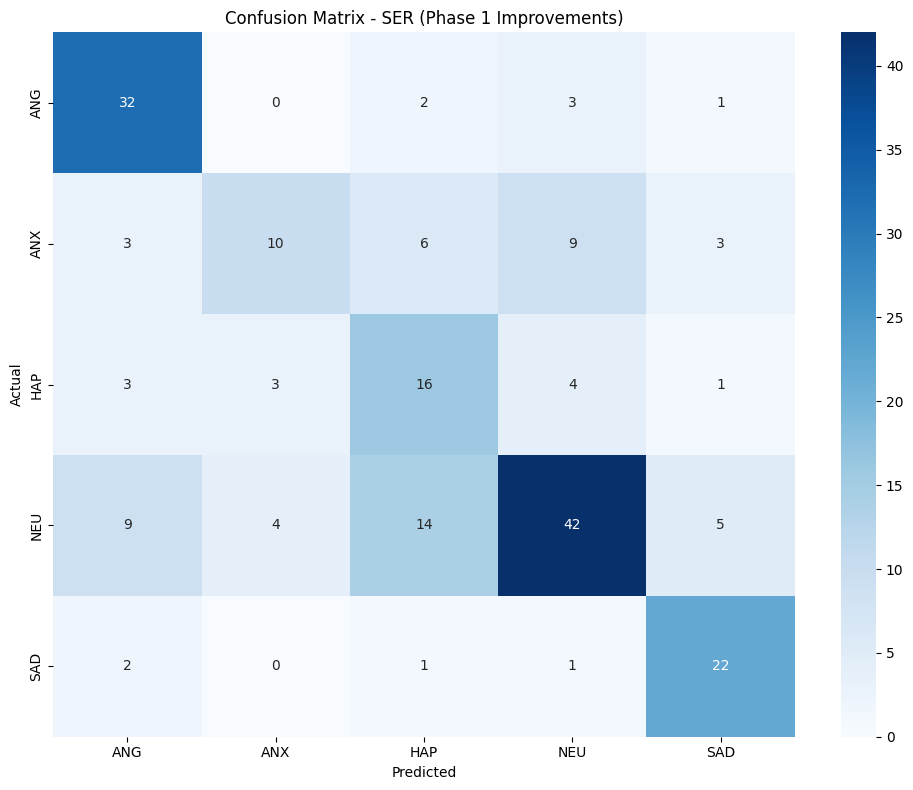


 PER-CLASS ACCURACY
  ✓ ANG: 84.21%
  ✓ ANX: 32.26%
  ✓ HAP: 59.26%
  ✓ NEU: 56.76%
  ✓ SAD: 84.62%

 OVERALL ACCURACY: 62.24%
 SUCCESS! Target >60% achieved!

 Target: >60% accuracy, all classes >30% recall


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(" Evaluating model on test set...")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(len(encoded_test)):
        item = encoded_test[i]
        input_features = torch.tensor(item["input_features"]).unsqueeze(0).to(device)
        label = item["labels"]
        
        outputs = model(input_features=input_features)
        pred = torch.argmax(outputs.logits, dim=-1).item()
        
        all_preds.append(pred)
        all_labels.append(label)

print("\n" + "="*60)
print(" CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=labels, zero_division=0))

print("\n" + "="*60)
print(" CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SER (Phase 1 Improvements)')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n" + "="*60)
print(" PER-CLASS ACCURACY")
print("="*60)
for i, label_name in enumerate(labels):
    class_mask = [l == i for l in all_labels]
    class_preds = [p for p, m in zip(all_preds, class_mask) if m]
    class_labels = [l for l, m in zip(all_labels, class_mask) if m]
    if len(class_labels) > 0:
        acc = sum(p == l for p, l in zip(class_preds, class_labels)) / len(class_labels)
        status = "✓" if acc > 0.3 else "✗"
        print(f"  {status} {label_name}: {acc*100:.2f}%")

# Overall
overall_acc = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
print(f"\n OVERALL ACCURACY: {overall_acc*100:.2f}%")

if overall_acc >= 0.6:
    print(" SUCCESS! Target >60% achieved!")
else:
    print(f" Current: {overall_acc*100:.1f}% (Target: >60%)")

print("\n Target: >60% accuracy, all classes >30% recall")